# Pratique de geopandas: données vélib

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2003_geopandas_TP%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=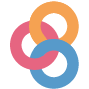" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Installations préalables :

In [2]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

In [3]:
import geopandas as gpd

# Lire et enrichir des données spatiales

Dans cette partie, nous utiliserons la fonction suivante,
le package [`cartiflette`](https://github.com/InseeFrLab/cartiflette.git)
qui facilite la récupération de contours de cartes.
Une version antérieure de cet exercice, présentée sous forme
d’exercice supplémentaire, utilisait des fonds de carte issus
de `data.gouv`.

In [4]:
# 0) Chargement des packages utilisés dans la partie tutoriel
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import cartiflette.s3

<div class="alert alert-success" role="alert">

1.  S’inspirer des exemples de code présents dans le chapitre précédent, mobilisant
    le package `cartiflette`
    pour télécharger les données communales.
    Vous pouvez nommer l’objet `communes_borders`
2.  Regarder les premières lignes des données. Identifier la différence avec
    un DataFrame standard.
3.  Afficher l’attribut `crs` de `communes_borders`. Ce dernier contrôle la
    transformation de l’espace tridimensionnel terrestre en une surface plane.
4.  Afficher les communes des Hauts de Seine (département 92) et utiliser la méthode
    `plot`
5.  Réprésenter la carte de Paris : quel est le problème ?

</div>

In [5]:
communes_borders = cartiflette.s3.download_vectorfile_url_all(
    values = ["75", "92", "93", "94"],
    level="COMMUNE",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

In [6]:
# 2) Regarder les premières lignes
communes_borders.head()
# Il y a une colonne geometry qui contient les informations nécessaires pour connaître les contours communaux

In [7]:
# 3) Afficher le crs
communes_borders.crs
# Les données ne sont pas projetées, elles sont en "longitude - latitude" (WGS 84)

In [8]:
# 4) afficher les communes du département 12
ax = communes_borders[communes_borders['INSEE_DEP'] == "92"].plot()
ax.set_axis_off()

In [9]:
# 5) Représenter la carte de Paris. Quel est le problème ?
ax = communes_borders[communes_borders['INSEE_DEP'] == "75"].plot()
ax.set_axis_off()

En effet, on ne dispose ainsi pas des limites des arrondissements parisiens, ce
qui appauvrit grandement la carte de Paris.
On pourrait les récupérer directement
depuis le site d’*open-data* du Grand Paris, ce qui est proposé en exercice supplémentaire.
On propose ici d’utiliser à nouveau
`cartiflette` pour cela afin de disposer du fonds de carte officiel.

<div class="alert alert-success" role="alert">

1.  Importer les données de découpage des arrondissements parisiens à l’adresse
    <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>
2.  Vérifier sur une carte que les découpages des arrondissements sont bien présents.
3.  Vérifier l’attribut `crs`. Est-il cohérent avec celui des données communales ?
4.  Retirer Paris du jeu de données communales et utiliser les arrondissements
    pour enrichir (nommer l’objet obtenu `data_borders`).
5.  Représenter à nouveau les communes de la petite couronne parisienne (75, 92, 93, 94)

</div>

In [10]:
#1) Importer arrondissements
arrondissements = cartiflette.s3.download_vectorfile_url_all(
    values = "75",
    level="ARRONDISSEMENT_MUNICIPAL",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

In [11]:
#2) Vérifier présence arrondissements
ax = arrondissements.plot(alpha = 0.8, edgecolor = "k")
ax.set_axis_off()

In [12]:
#3) Vérifier l'attribut `crs`. Est-il cohérent ?
print(communes_borders.crs)
print(communes_borders.crs == arrondissements.crs)
# Oui, les deux fonds de carte ont le même attribut CRS, pas besoin de convertir les projections de l'une d'entre elles

In [13]:
#4) Retirer Paris et ajouter les arrondissements
import pandas as pd

data_paris = pd.concat(
  [
    communes_borders[communes_borders['INSEE_DEP'] != "75"],
    arrondissements
  ])

La carte obtenue à l’issue de la question 6, c’est-à-dire après
avoir consolidé les données, devrait avoir l’aspect suivant:

In [14]:
#6) Représenter les communes du 75, 92, 93, 94
ax = data_paris.plot(alpha = 0.3, edgecolor = "k")
ax.set_axis_off()

# Utiliser des données géographiques comme des couches graphiques

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données.

On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

<div class="alert alert-success" role="alert">

1.  Importer les données velib sous le nom `station`
2.  Vérifier la projection géographique de `station` (attribut `crs`). Si celle-ci est différente des données communales, reprojeter ces
    dernières dans le même système de projection que les stations de vélib
3.  Représenter sur une carte les 50 stations les plus importantes (variable `capacity`). Vous pouvez également afficher le fonds de carte des arrondissements de Paris.
    Cette [page](https://geopandas.org/mapping.html#maps-with-layers) peut vous aider pour comprendre comment afficher plusieurs couches à la fois. Vous pouvez customiser la carte en retirant les axes grâce à la méthode `set_axis_off` et mettre un titre tel que *“Les 50 principales stations de Vélib”* avec la méthode `set_title`.
4.  Afficher également (trait bleu et épais) les réseaux de transport en communs, disponibles [ici](https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/map/?location=7,48.69717,2.33167&basemap=jawg.streets). L’url à requêter est
    <https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

</div>

In [15]:
# 1) Importer les données velib
url = "https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
stations = gpd.read_file(url)
stations.head()

In [16]:
# 2) Reprojection
stations.crs
data_paris = data_paris.to_crs(stations.crs)

La carte attendu à l’issue de la question 3 a l’aspect suivant:

In [17]:
# 3) Carte des 50 stations les plus importantes. 
base = data_paris[data_paris['INSEE_DEP'] == '75'].plot(alpha = 0.2, edgecolor = 'black')
stations.sort_values('capacity', ascending = False).head(50).plot(ax = base, color = 'red', alpha = 0.6)
base.set_axis_off()
base.set_title("Les 50 principales stations de Vélib")

L’ajout du réseau de métro permet d’obtenir une carte ressemblant à celle-ci

In [18]:
# 4) Réseaux de transport en communs
url = "https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
transports = gpd.read_file(url)
transports.head()
print(transports['mode'].unique())
base = data_paris[data_paris['INSEE_DEP'] == '75'].plot(alpha = 0.2, edgecolor = 'black')
stations.sort_values('capacity', ascending = False).head(50).plot(ax = base, color = 'red', alpha = 0.6)
transports[transports['mode'] == "METRO"].plot(ax=base, color = 'blue', alpha = 0.3,linewidth=3)
base.set_axis_off()
base.set_title("Les 50 principales stations de Vélib")

Pour faire une belle carte, il faudrait couper les lignes de métro via une jointure spatiale ou
utiliser un fonds de carte conceptuel.
L’exercice suivant propose de mettre en oeuvre la deuxième méthode. La première
est proposée en exercice supplémentaire.

<div class="alert alert-success" role="alert">

1.  Recréer par couche successive la carte précédente, que vous pouvez nommer `base`
2.  Utiliser `add_basemap` du package [`contextily`](https://contextily.readthedocs.io/en/latest/)
    pour ajouter, en arrière plan, un fonds de carte
3.  Jouer avec les fonds disponibles en utilisant l’argument `source`

</div>

Par exemple, en utilisant le fond `Stamen.Watercolor`, on obtient la carte
suivante. Celle-ci permet déjà de mieux localiser les stations.

In [19]:
base = data_paris[data_paris['INSEE_DEP'] == '75'].to_crs(3857).plot(alpha = 0.2, edgecolor = 'black')
stations.sort_values('capacity', ascending = False).head(50).to_crs(3857).plot(ax = base, color = 'red', alpha = 0.6)
base.set_axis_off()
base.set_title("Les 50 principales stations de Vélib")
ctx.add_basemap(base, source=ctx.providers.Stamen.Watercolor)

# Jointures spatiales

Les jointures attributaires fonctionnent comme avec un DataFrame `pandas`.
Pour conserver un objet spatial *in fine*, il faut faire attention à utiliser en premier (base de gauche) l’objet `GeoPandas`.
En revanche, l’un des intérêts des objets geopandas est qu’on peut également faire une jointure sur la dimension spatiale grâce à `sjoin`.

La documentation à laquelle se référer est [ici](https://geopandas.org/mergingdata.html#spatial-joins).

<div class="alert alert-success" role="alert">

1.  Faire une jointure spatiale pour enrichir les données de stations en y ajoutant des informations de `data_paris`. Appeler cet objet `stations_info`
2.  Représenter la carte des stations du 19e arrondissement (s’aider de la variable `c_ar`). Vous pouvez mettre en fond de carte les arrondissements parisiens.
3.  Compter le nombre de stations velib et le nombre de places velib par arrondissement ou commune (pour vous aider, vous pouvez compléter vos connaissances avec [ce tutoriel](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)). Représenter sur une carte chacune des informations
4.  Représenter les mêmes informations mais en densité (diviser par la surface de l’arrondissement ou commune en km2)
5.  (optionnel) Choisir une des cartes de densité et la nettoyer (retirer les axes, mettre les titres…)

</div>

In [20]:
#1.  Jointure spatiale entre stations et data_paris
stations_info = gpd.sjoin(stations, data_paris, op = 'within')
stations_info.head()

In [21]:
#2. Carte des stations du 19e arrondissement
# Méthode 1 : En affichant tout Paris
base = data_paris[data_paris['INSEE_DEP'] == "75"].plot(alpha = 0.2, edgecolor = 'k') #fond de carte des arrondissements
stations_19 = stations_info.loc[stations_info['NOM'].str.contains("19e")]
stations_19.plot(ax = base, color = 'red', alpha = 0.6) # stations du 19e
# Méthode 2 : En affichant seulement le 19e
base = data_paris[data_paris['NOM'].str.contains("19e")].to_crs(3857).plot(alpha = 0.2, edgecolor = 'k') #fond de carte du 19e
stations_info[stations_info['NOM'].str.contains("19e")].to_crs(3857).plot(ax = base, color = 'red', alpha = 0.6) #stations du 19e
ctx.add_basemap(base, source=ctx.providers.Stamen.Toner)

In [22]:
#3. Nombre de stations et de places vélib par arrondissement
stations_agg = stations_info.groupby('NOM').agg({'stationcode': 'nunique',
                                   'capacity': 'sum'}).reset_index()
stations_agg.head()
df = data_paris.merge(stations_agg, how = 'inner')
df.head()
df.plot(column = 'capacity', legend=True)
df.plot(column = 'stationcode', legend=True)

In [23]:
#4. En densité
cols = ['stationcode','capacity']
df[[s + '_density' for s in cols]] = df[cols].div(df.to_crs(2158).area*10**(-6), axis = 0)
df.plot(column = 'capacity_density', cmap = 'RdYlBu_r', legend=True)
df.plot(column = 'capacity_density', cmap = 'plasma_r', legend=True)

In [24]:
ax = df.plot(column = 'capacity_density', cmap = 'RdYlBu_r', legend=True, legend_kwds={"orientation": "horizontal", "pad": 0.01}) 
ax.set_axis_off()
ax.set_title("Densité des stations vélib dans l'agglomération parisienne")

# Trouver les toilettes publiques les plus proches

Une aide [ici](https://pysal.org/scipy2019-intermediate-gds/deterministic/gds1-relations.html#how-about-nearest-neighbor-joins)

Cet exemple peut également vous aider à comprendre certains concepts :

In [26]:
from shapely.ops import Polygon
from shapely.ops import nearest_points
triangle = Polygon([(0, 0), (1, 0), (0.5, 1), (0, 0)])
square = Polygon([(0, 2), (1, 2), (1, 3), (0, 3), (0, 2)])
[o.wkt for o in nearest_points(triangle, square)]

<div class="alert alert-success" role="alert">

1.  Charger la localisation des toilettes publiques présente ici : https://data.ratp.fr/explore/dataset/sanitaires-reseau-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr. Appelez-la `toilettes_publiques`.
2.  Trouver les toilettes publiques les plus proches de la station de vélib “Edgard Quinet - Gaité”. La ligne de code `ensemble_toilettes = toilettes_publiques.unary_union` vous sera utile ainsi que l’importation de la fonction `from shapely.ops import nearest_points`.
3.  Généraliser aux 10 premières lignes de la table `stations` des vélibs en indiquant pour chaque station velib quelle sont les toilettes publiques les plus proches dans une nouvelle colonne appelée `Nearest`.

</div>

In [27]:
# 1. Charger les localisations des toilettes
toilettes_publiques = gpd.read_file("https://data.ratp.fr/explore/dataset/sanitaires-reseau-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
toilettes_publiques.head()

In [28]:
# 2. Trouver la station de toilettes la plus proche de la station de vélib "Edgard Quinet - Gaité"
ensemble_toilettes = toilettes_publiques.unary_union
ensemble_toilettes
from shapely.ops import nearest_points
edgard_quinet_gaite = stations[stations.name == 'Edgar Quinet - Gaité'].iloc[0,] #le iloc est fait pour passer d'un pd à un pd.series, sinon bug.
nearest = nearest_points(edgard_quinet_gaite['geometry'], ensemble_toilettes)[1]
toilettes_publiques[toilettes_publiques['geometry'] == nearest][:1]
# Il va falloir se retenir un peu car s'agit de toilettes situées à la station Denfert Rochereau !

In [29]:
# A améliorer dans la forme du code (je suis passée par des listes alors que je n'aurais probablement pas du). KA

#3. Fonction qui généralise aux 10 premières stations de la base de données
def find_nearest(numero_station):
      station_choisie = stations.iloc[numero_station,]
      nearest = nearest_points(station_choisie['geometry'], ensemble_toilettes)[1]
      return toilettes_publiques[toilettes_publiques['geometry'] == nearest][:1]['station']

dix_premieres_stations = stations.tail(10)
dix_premieres_stations['Nearest'] = [list(find_nearest(num_station))[0] for num_station in dix_premieres_stations.index]
dix_premieres_stations

In [30]:
# Ancienne correction de Lino
# un truc comme ça à revoir mais là fait des NaN :'(
from shapely.ops import nearest_points
temp = stations_transport.unary_union
def find_nearest(geometry1, geometry2 = temp, df_point2 = stations_transport):
    nearest = nearest_points(geometry1, geometry2)[1]
    return df_point2[df_point2['geometry'] == nearest][:1]['nomptar']
stations['Nearest'] = stations.apply(lambda row: find_nearest(row.geometry), axis=1)

In [31]:
import geopandas as gpd
import urllib.request
import gzip

url = "https://int.nyt.com/newsgraphics/elections/map-data/2020/national/precincts-with-results.geojson.gz"
# urllib.request.urlretrieve(url, "votes.gz")

url2 = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
urllib.request.urlretrieve(url2, "states.zip")

import gzip
import shutil
with gzip.open('votes.gz', 'rb') as f_in:
    with open('votes.geojson', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
import zipfile
with zipfile.ZipFile("states.zip", 'r') as zip_ref:
    zip_ref.extractall("states.shp")

votes = gpd.read_file('votes.geojson')
states = gpd.read_file("states.shp")
votes['states'] = votes['GEOID'].str[:2]

# alternative (plus rapide)
essai = pd.read_csv("https://github.com/MEDSL/2020-elections-official/raw/main/PRESIDENT/PRESIDENT_precinct_general.csv.zip")
essai.dropna(subset = ["party_simplified"]).groupby(["county_fips",'party_simplified']).agg({"votes": "sum"})

# Exercices supplémentaires

Voici une fonction pour télécharger et dézipper
facilement un fonds de carte issu de `data.gouv`

In [32]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

Importer le fichier avec le package `GeoPandas`
(si vous avez laissé les paramètres par défaut,
le fichier devrait
être à l’emplacement `temporary_location + "/borders/communes-20210101.shp"`).

In [33]:
# 1) télécharger les données communales
url = "https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
download_unzip(url)

In [34]:
# 2) Importer le fichier
#communes_borders = gpd.read_file(temporary_location + "/borders/communes-20220101.shp")

1.  Importer les données de découpage des arrondissements parisiens à l’adresse
    <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>
2.  Vérifier sur une carte que les découpages des arrondissements sont bien présents.
3.  Vérifier l’attribut `crs`. Est-il cohérent avec celui des données communales ?
4.  Retirer Paris du jeu de données communales et utiliser les arrondissements
    pour enrichir (nommer l’objet obtenu `data_borders`). Ici, on peut ne pas se
    soucier de la variable commune de superficie aux niveaux différents car on
    va la recréer. En revanche, renommer la variable `c_arinsee` en `insee` avec
    la méthode `rename` et faire attention aux types des variables
5.  Créer une variable `dep` stockant le département

In [35]:
#1) Importer arrondissements
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

In [36]:
#2) Vérifier présence arrondissements
arrondissements.plot()

In [37]:
#3) Vérifier l'attribut `crs`. Est-il cohérent ?
print(communes_borders.crs)
print(communes_borders.crs == arrondissements.crs)
# Oui, les deux fonds de carte ont le même attribut CRS, pas besoin de convertir les projections de l'une d'entre elles

In [38]:
#4) Retirer Paris et ajouter les arrondissements
## On fait en sorte que les colonnes de arrondissements soient les mêmes que celles de communes borders
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['dep'] = "75"
# On sélectionne enlève la ligne du contour de Paris initiale, et on ajoute à la place les lignes d'arrondissements
data_paris = communes_borders[~communes_borders.insee.str.startswith("75")].append(arrondissements)
data_paris.tail()

In [39]:
#5)  Créer une variable `dep`
print(data_paris['dep'])
# Il y a des NA qui proviennent de la base communes_borders
# donc on recrée la var dep
data_paris['dep'] = data_paris.insee.astype(str).str[:2]

## Jointures spatiales

L’objectif de cet exercice est de ne conserver que les
lignes de transports à l’intérieur de Paris intra-muros

<div class="alert alert-success" role="alert">

``` python
url = "https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
transports = gpd.read_file(url)
transports_paris = transports.sjoin(data_paris.loc[data_paris['INSEE_DEP']=="75"], how="inner", predicate="within")

paris = data_paris.loc[data_paris['INSEE_DEP']=="75"].geometry.unary_union
base = data_paris[data_paris['INSEE_DEP'] == '75'].plot(alpha = 0.2, edgecolor = 'black')
transports[transports.geometry.within(paris)].plot(ax=base, column='mode', alpha = 0.9, linewidth=3)
```

</div>